# Exploratory Data Analysis (EDA) - Airbnb listings from Rio de Janeiro
## This EDA has two sections: Listings EDA and Amenities EDA

### Project overview: 
As Airbnb has become a popular alternative to hotels for vacations, the competitivity between listings has increased substancially with varied features in each acommodation. Therefore, in order for listings to stay relevant and succesfull, they must offer a good service while optimizing their investments by focusing on the most relevant features for the average user. <br/>
Knowing that Rio de Janeiro is a famous city among local and international tourists due to its media traction, it's seems reasonable to assume that the listings can be summarized in aspects such as features offered by the host and intrinsic features of its region, since different regions present different socioeconomic indicators.

### Problem definition:
The objective of this project is to understand how the success of an Airbnb can be determined based on the information displayed to the customer.

### Dataset relevant context:
As mentioned in the link below the occupancy can be estimated using the number of reviews and a review rate (the ratio of total guests and the guests that review the Airbnb).
http://insideairbnb.com/about.html

### EDA checklist:
* Listings: How are the features distributed in the dataset?
* Listings: Which metrics are the most adequate to measure the success of an Airbnb?
* Listings: How are the features correlated?
* Amenities: NLP approach analysis
* Amenities: Correlation analysis
* Complete dataset characterization

In [1]:
# System path setup
import os
import sys

print('Project root location in: \n' + os.path.abspath('')[:-9])

data_filepath = os.path.abspath('')[:-9] + '/data/'
sys.path.insert(0, os.path.abspath('')[:-9] + '/modules/')

Project root location in: 
/Users/leonardoyamaguishi/Documents/Udacity/data_science_capstone_project/


In [2]:
# Importing libraries for Data Handling and EDA
import pandas as pd
import numpy as np
import scipy
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from apriori_python import apriori

# Plotting liberaries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from modelling_support import above_median_metric

In [3]:
amenities = pd.read_csv(data_filepath + 'amenities_post_etl.csv', index_col = 0)
listings = pd.read_csv(data_filepath + 'listings_post_etl.csv', index_col = 0)

## Listings EDA

### Dataset integrity deep dive

In [4]:
listings.head()

id  host_id  host_response_time  host_response_rate  host_is_superhost  \
0  17878    68997                 1.0                 1.0                  0   
1  24480    99249                 4.0                 1.0                  0   
2  25026   102840                 3.0                 0.8                  0   
3  35636   153232                 1.0                 1.0                  1   
4  35764   153691                 1.0                 1.0                  1   

   host_has_profile_pic  host_identity_verified  accommodates  bedrooms  beds  \
0                     1                       1             5       2.0   2.0   
1                     1                       1             2       1.0   1.0   
2                     1                       1             3       1.0   1.0   
3                     1                       1             2       1.0   1.0   
4                     1                       1             2       1.0   1.0   

   ...  hotel_room  private_room  shared_room  walking_dist_stations_scores  \
0  ...           0             0            0                          -1.0   
1  ...           0             0            0                           4.1   
2  ...           0             0            0                          -1.0   
3  ...           0             0            0                           4.1   
4  ...           0             0            0                           4.1   

   per_capita_income_2000  longevity_index  education_index  income_index  \
0             1623.415521         0.879608         0.989888           1.0   
1             2465.445144         0.894594         0.991860           1.0   
2             1623.415521         0.879608         0.989888           1.0   
3             2465.445144         0.894594         0.991860           1.0   
4             1623.415521         0.879608         0.989888           1.0   

   human_development_index  neighbourhood_key  
0                 0.956499                 11  
1                 0.962151                  3  
2                 0.956499                 11  
3                 0.962151                  3  
4                 0.956499                 11  

[5 rows x 35 columns]

In [5]:
def missing_values_ratio(df):
    '''
    INPUTS:
    df - (DataFrame) in which the ratio of nan's will be evaluated
    OUTPUTS:
    na_ratio_series - (Series) numeric ratio of nan's
    '''
    # Checking for the ratios of nan values (count of na/ number of rows)
    df_na_ratio = df.isna().sum()/df.shape[0]

    # Filtering the dataset to show only ratios > 0 
    df_na_ratio = df_na_ratio[df_na_ratio>0]

    # Sorting values
    df_na_ratio.sort_values(ascending = False, inplace = True)

    # Visalizing data
    sns.barplot(x = df_na_ratio.values, y = df_na_ratio.index)
    plt.xlim(0,1)
    plt.show()
    
    return df_na_ratio

In [6]:
def multiple_hist(df, columns_to_plot):
    '''
    INPUTS:
    df - (DataFrame)
    columns_to_plot - (list) of columns from df to print
    OUTPUTS:
    None
    '''
    for data in columns_to_plot:
        sns.histplot(listings[data])
        plt.figure(figsize = (10, 10))
        plt.show()

In [7]:
def shapiro_wil_normality_test(df, columns_to_plot, alpha = 0.05):
    '''
    INPUTS:
    df - (DataFrame)
    columns_to_plot - (list) of columns to perform the Shapiro-Wilk test for normality
    
    DESCRIPTION:
    The null hypothesis (H0) is that the data is normally distributed, therefore, if p < alpha, there`s evidence that
    the data is not normally distributed
    
    OUTPUTS:
    (DataFrame) with the column names and their normality test results
    '''
    statistic_list = []
    p_value_list = []
    outcome = []
    
    for data in columns_to_plot:
        test = scipy.stats.shapiro(listings[data])
        statistic_list.append(test.statistic)
        p_value_list.append(test.pvalue)
        
        if test.pvalue > alpha:
            outcome.append('not discarded')
        else:
            outcome.append('discarded')
            
        
    return pd.DataFrame({'column' : columns_to_plot, 
                        'shapiro_wilk_statistic': statistic_list,
                        'p_value' : p_value_list, 
                        'h0': outcome})

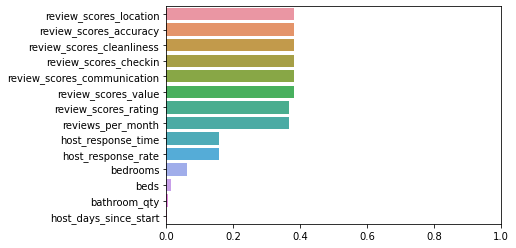

In [8]:
# Checking for the ratios of nan values (count of na/ number of rows)
listings_na_ratio = missing_values_ratio(listings)

In [9]:
# As visualized in the plot above and in the Series below, 
# the review_scores features have very similar rations
# probably because their are collected "at the same time" for each user
listings_na_ratio

review_scores_location         0.380341
review_scores_accuracy         0.380301
review_scores_cleanliness      0.380301
review_scores_checkin          0.380301
review_scores_communication    0.380260
review_scores_value            0.380260
review_scores_rating           0.365025
reviews_per_month              0.365025
host_response_time             0.158092
host_response_rate             0.158092
bedrooms                       0.060695
beds                           0.014135
bathroom_qty                   0.003707
host_days_since_start          0.000611
dtype: float64

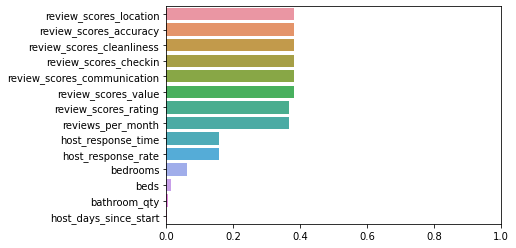

In [10]:
# Nan's ratio evaluation
listings_na_ratio = missing_values_ratio(listings)

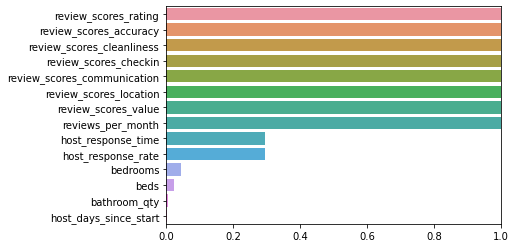

In [11]:
# Knowing that the reviews_per_month is metric that will lead the analysis to a metric of success
# it's reasonable  to evaluate if the nans from reviews_per_mont coincide with the review_scores
missing_review_count_df = listings[listings.reviews_per_month.isna()]
missing_review_count_series = missing_values_ratio(missing_review_count_df)

In [12]:
# Nan handling, as the source website doesn`t describe the reason for the NaN values
# The chosen approach was to drop the NaN
listings.dropna(inplace = True)

# Listings: How are the features distributed in the dataset?

In [13]:
# understanding the data distribution
listings_explicit_features = ['host_is_superhost',
                             'host_has_profile_pic',
                             'host_identity_verified',
                             'accommodates',
                             'bedrooms',
                             'beds',
                             'minimum_nights_avg_ntm',
                             'maximum_nights_avg_ntm',
                             'reviews_per_month',
                             'host_days_since_start',
                             'bathroom_qty',
                             'shared_bathroom']

listings_implicit_features = ['walking_dist_stations_scores',
                             'per_capita_income_2000',
                             'longevity_index',
                             'education_index',
                             'income_index',
                             'human_development_index']

listings_rating_related_features = ['review_scores_location',
                                    'review_scores_accuracy',
                                    'review_scores_cleanliness',
                                    'review_scores_checkin',
                                    'review_scores_communication']

quantitative_input_data = ['accommodates',
                         'bedrooms',
                         'beds',
                         'minimum_nights_avg_ntm',
                         'maximum_nights_avg_ntm',
                         'host_days_since_start',
                         'bathroom_qty', 
                         'walking_dist_stations_scores', 
                         'per_capita_income_2000',
                         'longevity_index',
                         'education_index',
                         'income_index',
                         'human_development_index', 
                         'review_scores_location',
                         'review_scores_accuracy',
                         'review_scores_cleanliness',
                         'review_scores_checkin',
                         'review_scores_communication']

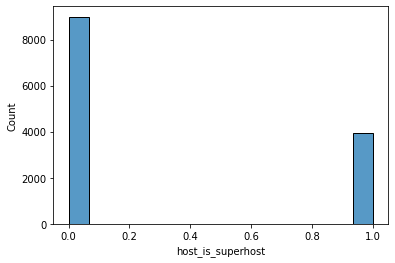

<Figure size 720x720 with 0 Axes>

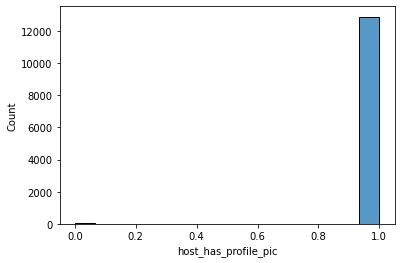

<Figure size 720x720 with 0 Axes>

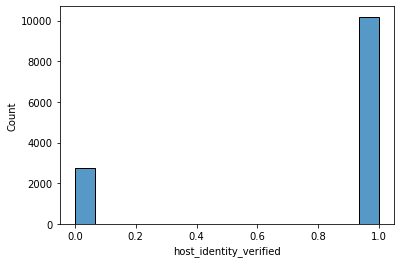

<Figure size 720x720 with 0 Axes>

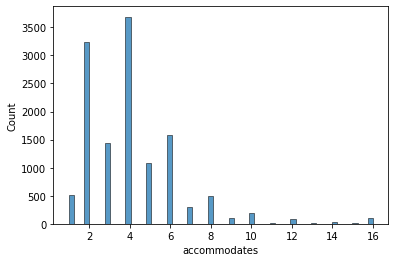

<Figure size 720x720 with 0 Axes>

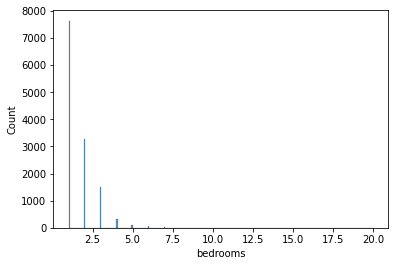

<Figure size 720x720 with 0 Axes>

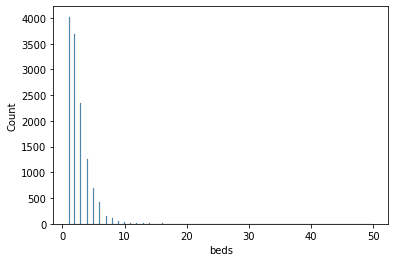

<Figure size 720x720 with 0 Axes>

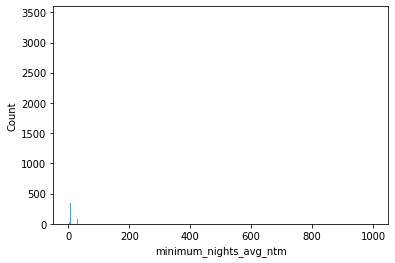

<Figure size 720x720 with 0 Axes>

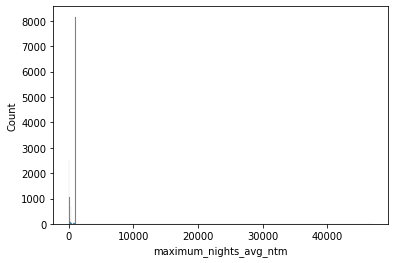

<Figure size 720x720 with 0 Axes>

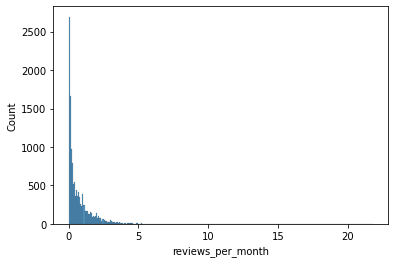

<Figure size 720x720 with 0 Axes>

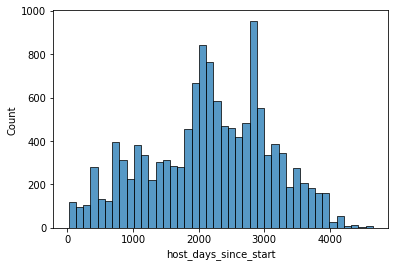

<Figure size 720x720 with 0 Axes>

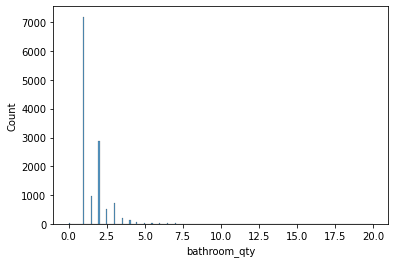

<Figure size 720x720 with 0 Axes>

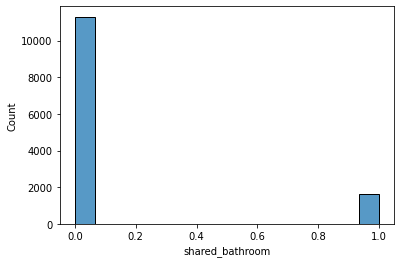

<Figure size 720x720 with 0 Axes>

In [14]:
# Distribution from the explicit features
multiple_hist(listings, listings_explicit_features)

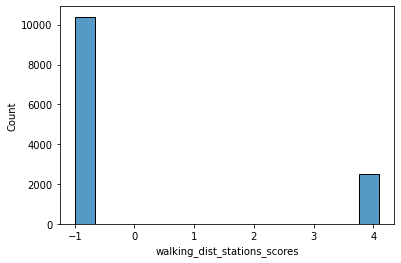

<Figure size 720x720 with 0 Axes>

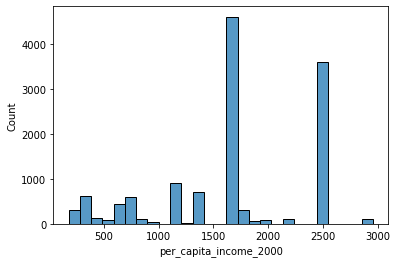

<Figure size 720x720 with 0 Axes>

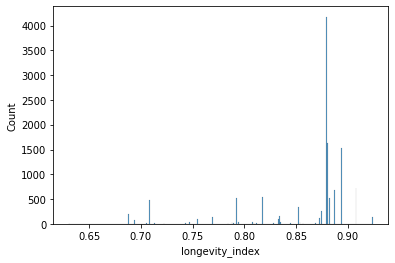

<Figure size 720x720 with 0 Axes>

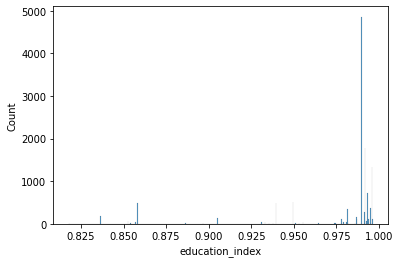

<Figure size 720x720 with 0 Axes>

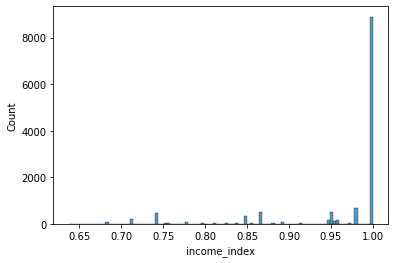

<Figure size 720x720 with 0 Axes>

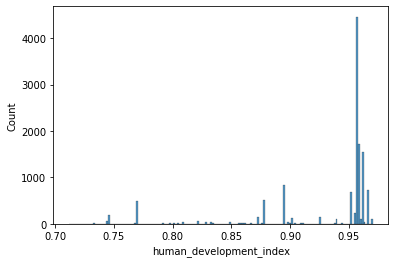

<Figure size 720x720 with 0 Axes>

In [15]:
# Distribution from the implicit features
multiple_hist(listings, listings_implicit_features)

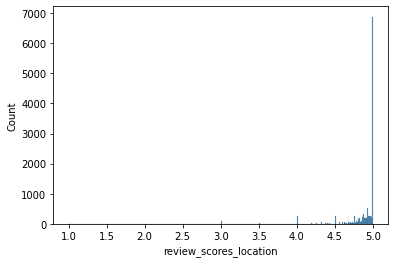

<Figure size 720x720 with 0 Axes>

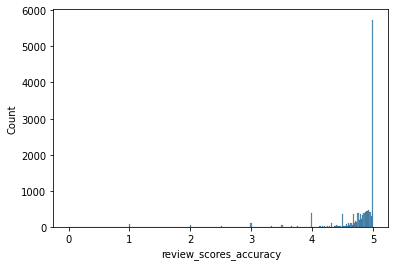

<Figure size 720x720 with 0 Axes>

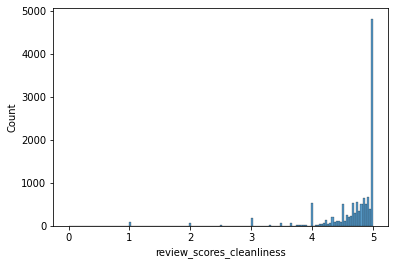

<Figure size 720x720 with 0 Axes>

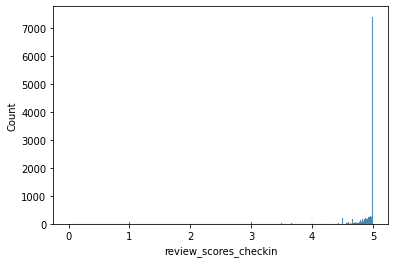

<Figure size 720x720 with 0 Axes>

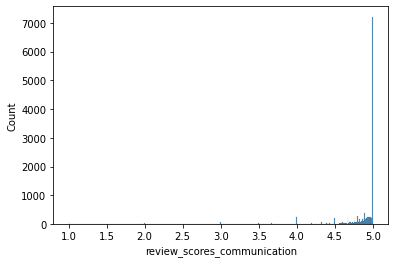

<Figure size 720x720 with 0 Axes>

In [16]:
multiple_hist(listings, listings_rating_related_features)

In [17]:
shapiro_wil_normality_test(listings, listings_explicit_features)

/Users/leonardoyamaguishi/miniconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


column  shapiro_wilk_statistic       p_value         h0
0        host_is_superhost                0.578093  0.000000e+00  discarded
1     host_has_profile_pic                0.019623  0.000000e+00  discarded
2   host_identity_verified                0.501780  0.000000e+00  discarded
3             accommodates                0.835000  0.000000e+00  discarded
4                 bedrooms                0.636080  0.000000e+00  discarded
5                     beds                0.646940  0.000000e+00  discarded
6   minimum_nights_avg_ntm                0.087142  0.000000e+00  discarded
7   maximum_nights_avg_ntm                0.371381  0.000000e+00  discarded
8        reviews_per_month                0.704407  0.000000e+00  discarded
9    host_days_since_start                0.985221  2.121813e-34  discarded
10            bathroom_qty                0.620699  0.000000e+00  discarded
11         shared_bathroom                0.388194  0.000000e+00  discarded

In [18]:
shapiro_wil_normality_test(listings, listings_implicit_features)

/Users/leonardoyamaguishi/miniconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


column  shapiro_wilk_statistic  p_value         h0
0  walking_dist_stations_scores                0.483881      0.0  discarded
1        per_capita_income_2000                0.902051      0.0  discarded
2               longevity_index                0.682104      0.0  discarded
3               education_index                0.536348      0.0  discarded
4                  income_index                0.572650      0.0  discarded
5       human_development_index                0.605081      0.0  discarded

In [19]:
shapiro_wil_normality_test(listings, listings_rating_related_features)

/Users/leonardoyamaguishi/miniconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


column  shapiro_wilk_statistic  p_value         h0
0       review_scores_location                0.404809      0.0  discarded
1       review_scores_accuracy                0.466704      0.0  discarded
2    review_scores_cleanliness                0.596318      0.0  discarded
3        review_scores_checkin                0.341411      0.0  discarded
4  review_scores_communication                0.375099      0.0  discarded

## Listings: Which metrics are the most adequate to measure the success of an Airbnb?

In [20]:
# Selecting a sample of the neighbourhoods 
neighbourhood_keys = list(set(listings.neighbourhood_key))

neighbourhoods_sample = shuffle(neighbourhood_keys, random_state = 123)[0: 20]

index_not_in_sample = []

for index in listings.index:
    if listings['neighbourhood_key'][index] not in neighbourhoods_sample:
        index_not_in_sample.append(index)

sample_listings = listings.drop(index_not_in_sample)

In [21]:
px.box(sample_listings, y="reviews_per_month", x="neighbourhood_key", color="neighbourhood_key")

In [22]:
px.histogram(sample_listings, x="reviews_per_month", color="neighbourhood_key")

In [23]:
rev_per_month_dict = {}

for key in neighbourhoods_sample:
    rev_per_month_dict[key] = listings[listings['neighbourhood_key'] == key]['reviews_per_month']

In [24]:
# Cell used to obtain a list of the reviews_per_month for the ANOVA below
# for key in rev_per_month_dict:
#     print("rev_per_month_dict[{}],".format(key))

In [25]:
# Performing ANOVA to evaluate if the reviews_per_month feature is distributed differently between the neighbourhoods
# H0 - The reviews_per_month features has the same distribution for each neighbourhood

scipy.stats.f_oneway(rev_per_month_dict[4],
                    rev_per_month_dict[142],
                    rev_per_month_dict[109],
                    rev_per_month_dict[94],
                    rev_per_month_dict[45],
                    rev_per_month_dict[28],
                    rev_per_month_dict[29],
                    rev_per_month_dict[133],
                    rev_per_month_dict[114],
                    rev_per_month_dict[33],
                    rev_per_month_dict[16],
                    rev_per_month_dict[69],
                    rev_per_month_dict[24],
                    rev_per_month_dict[8],
                    rev_per_month_dict[5],
                    rev_per_month_dict[0],
                    rev_per_month_dict[13],
                    rev_per_month_dict[136],
                    rev_per_month_dict[82],
                    rev_per_month_dict[70])

F_onewayResult(statistic=4.758253565496268, pvalue=6.911828426996714e-11)

Even though the distributions were visually skewed in the boxplot, he null hypothesis (H0) from the ANOVA test was also discarded, therefore, there's evidence that each neighbourhood has a different reviews_per_month distribution, therefore, it seems reasonable to use a metric to compensate such differences. <br />
Therefore, a reasonable metric for the listings performance is using the median for each neighbourhood

In [26]:
# Applying the above_median_metric function created for this dataset
        
listings = above_median_metric(listings)

# Listings: How are the features correlated?

In [27]:
def correlation_analysis(df, method):
    '''
    INPUTS:
    df - (DataFrame) in which the features will have their correlations measures
    method - (string) with the method name ['spearman', 'pearson']
    OUTPUTS:
    df_corr_matrix - (matrix) of correlations
    '''
    # Correlation matrix plot: https://seaborn.pydata.org/examples/many_pairwise_correlations.html
    df_corr_matrix = df.corr(method = method)
    
    #Generating masks
    mask = np.triu(np.ones_like(df_corr_matrix, dtype=bool))

    f, ax = plt.subplots(figsize=(11, 9))
    fig = sns.heatmap(df_corr_matrix, mask=mask, cmap = 'PiYG', vmax=1, vmin = -1,center=0, square=True)
    
    return df_corr_matrix

host_response_time  host_response_rate  \
host_response_time                      1.000000           -0.632834   
host_response_rate                     -0.632834            1.000000   
host_is_superhost                      -0.342004            0.288176   
host_has_profile_pic                   -0.003894           -0.000844   
host_identity_verified                 -0.201717            0.131488   
accommodates                           -0.048741            0.018266   
bedrooms                                0.017272           -0.008836   
beds                                   -0.022174            0.015812   
price                                  -0.127924            0.059455   
minimum_nights_avg_ntm                 -0.007888            0.081623   
maximum_nights_avg_ntm                 -0.112406            0.080894   
review_scores_rating                    0.015942            0.043396   
review_scores_accuracy                  0.028828            0.026928   
review_scores_cleanliness               0.007025            0.049886   
review_scores_checkin                   0.086760           -0.024064   
review_scores_communication             0.049228            0.018299   
review_scores_location                  0.042364           -0.034864   
review_scores_value                    -0.000914            0.036986   
host_days_since_start                   0.039505           -0.014937   
bathroom_qty                            0.030768           -0.011894   
shared_bathroom                         0.098641           -0.065044   
entire_home_apt                        -0.144472            0.115346   
hotel_room                             -0.014342           -0.009060   
private_room                            0.132405           -0.102154   
shared_room                             0.060692           -0.050015   
walking_dist_stations_scores           -0.068131            0.016478   
per_capita_income_2000                 -0.044011            0.025104   
longevity_index                        -0.029139            0.021058   
education_index                        -0.031539            0.023808   
income_index                           -0.067325            0.044524   
human_development_index                -0.053589            0.032182   
above_median                           -0.368657            0.271265   

                              host_is_superhost  host_has_profile_pic  \
host_response_time                    -0.342004             -0.003894   
host_response_rate                     0.288176             -0.000844   
host_is_superhost                      1.000000              0.029100   
host_has_profile_pic                   0.029100              1.000000   
host_identity_verified                 0.178395              0.011752   
accommodates                           0.028709              0.001095   
bedrooms                              -0.013262             -0.004830   
beds                                   0.004036              0.000279   
price                                  0.081216             -0.001274   
minimum_nights_avg_ntm                 0.059026              0.005595   
maximum_nights_avg_ntm                 0.087934              0.011102   
review_scores_rating                   0.085626             -0.030229   
review_scores_accuracy                 0.048898             -0.024593   
review_scores_cleanliness              0.062205             -0.011008   
review_scores_checkin                 -0.035999             -0.016065   
review_scores_communication            0.011705             -0.018531   
review_scores_location                -0.059404             -0.025794   
review_scores_value                    0.073904             -0.029229   
host_days_since_start                  0.065608              0.055661   
bathroom_qty                          -0.015107             -0.004316   
shared_bathroom                       -0.077411              0.011363   
entire_home_apt                        0.102345

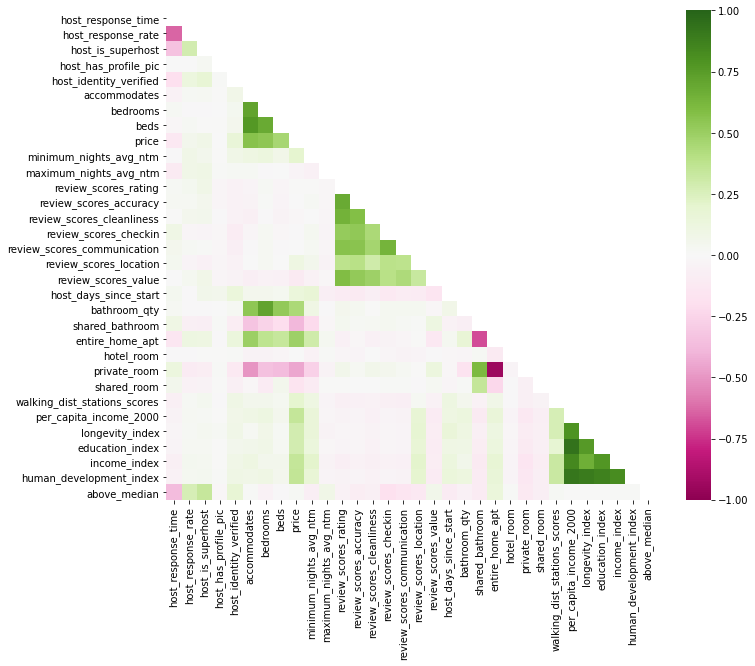

In [28]:
listings_corr = listings.drop(['id', 'host_id', 'neighbourhood_key', 'reviews_per_month'], axis = 1)

correlation_analysis(listings_corr, 'spearman')

review_scores_rating  review_scores_accuracy  \
review_scores_rating                     1.000000                0.680626   
review_scores_accuracy                   0.680626                1.000000   
review_scores_cleanliness                0.642616                0.580698   
review_scores_checkin                    0.517763                0.538096   
review_scores_communication              0.566038                0.557943   
review_scores_location                   0.378768                0.397591   
review_scores_value                      0.589548                0.525199   

                             review_scores_cleanliness  review_scores_checkin  \
review_scores_rating                          0.642616               0.517763   
review_scores_accuracy                        0.580698               0.538096   
review_scores_cleanliness                     1.000000               0.439336   
review_scores_checkin                         0.439336               1.000000   
review_scores_communication                   0.461999               0.638037   
review_scores_location                        0.302802               0.389543   
review_scores_value                           0.485195               0.393966   

                             review_scores_communication  \
review_scores_rating                            0.566038   
review_scores_accuracy                          0.557943   
review_scores_cleanliness                       0.461999   
review_scores_checkin                           0.638037   
review_scores_communication                     1.000000   
review_scores_location                          0.378984   
review_scores_value                             0.430496   

                             review_scores_location  review_scores_value  
review_scores_rating                       0.378768             0.589548  
review_scores_accuracy                     0.397591             0.525199  
review_scores_cleanliness                  0.302802             0.485195  
review_scores_checkin                      0.389543             0.393966  
review_scores_communication                0.378984             0.430496  
review_scores_location                     1.000000             0.335379  
review_scores_value                        0.335379             1.000000

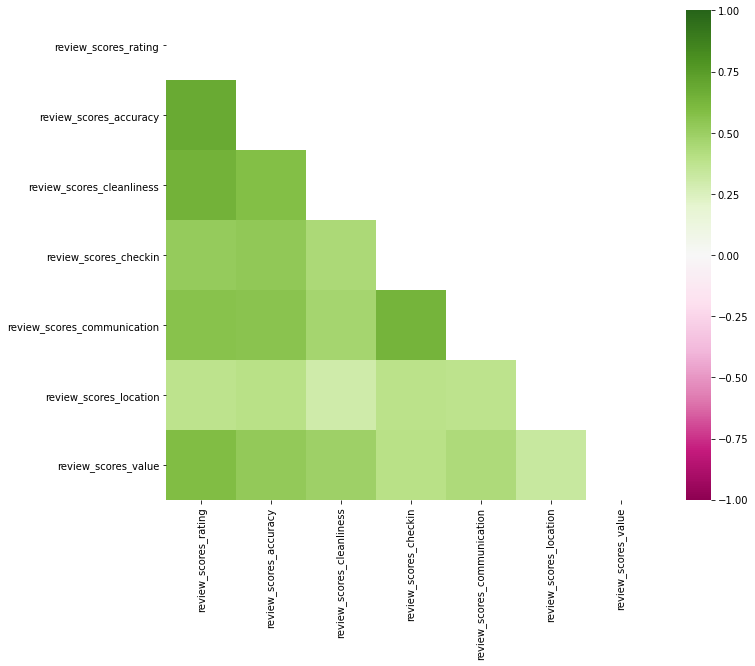

In [29]:
reviews_score_corr = listings[['review_scores_rating',
                               'review_scores_accuracy', 
                               'review_scores_cleanliness',
                               'review_scores_checkin', 
                               'review_scores_communication', 
                               'review_scores_location', 
                               'review_scores_value']]

# Evaluating if the review_scores are correlated
correlation_analysis(reviews_score_corr, 'spearman')

# As seen in the graph below, the review_scores are not strongly correlated
# therefore, these features could be treated as different features

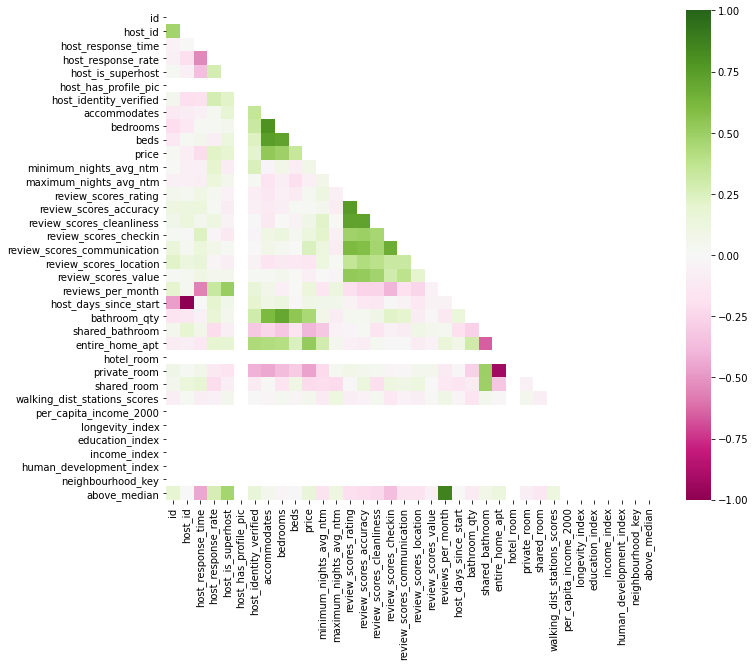

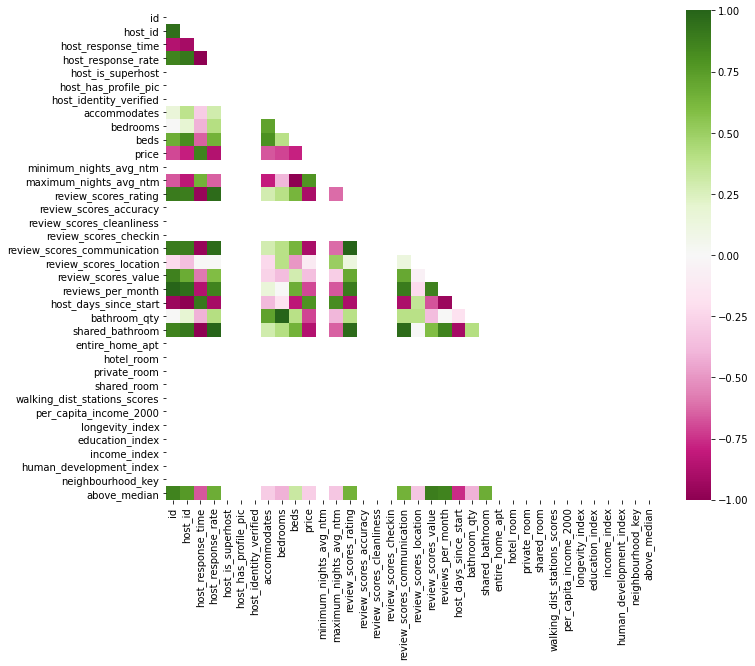

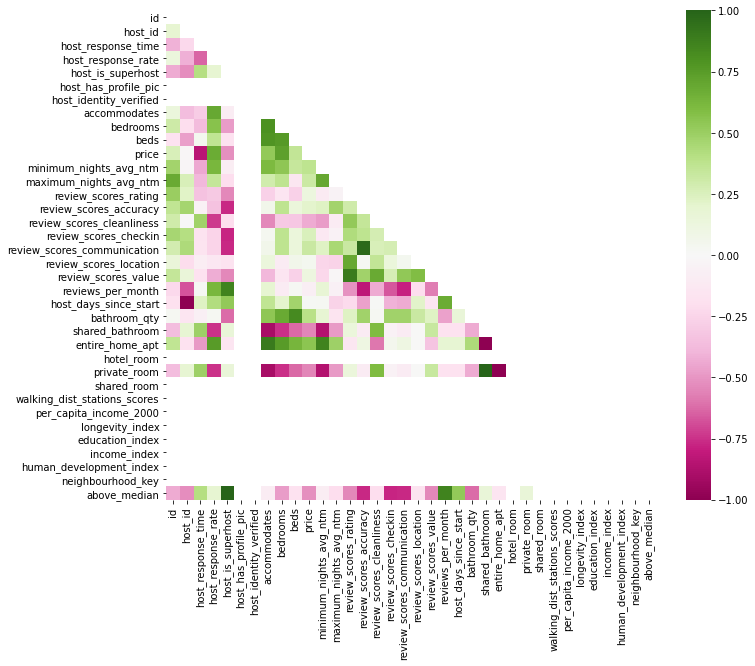

In [30]:
# Creating subsamples to analyze if the correlations are stronger when the neighbourhoods are separated
neighbourhoods_subsample = neighbourhoods_sample[0:3]

for key in neighbourhoods_subsample:
    correlation_analysis(listings[listings['neighbourhood_key'] == key], 'spearman')
    
# By analysing the correlations per neighbourhood
# it seems that the correlations become stronger
# The negative outcome of treating the neighbourhoods separately is that the socioeconomic metrics become single points

# Amenities: Prepare a NLP approach
The proposed approach for this project is to use the apriori algorithm to determine the most common word combinations in the amenities dataset (bag of words for each word). <br />
The objective is to simplify the dataset, obtaining the most common amenities (normally composed nouns) in order to evaluate how effective they can be in terms of attracting more guests.

In [31]:
from apriori_module import count_tokens
from apriori_module import list_relevant_columns
from apriori_module import ratio_of_true_values_single_values
from apriori_module import evaluate_apriori_sets
from apriori_module import create_item_set
from apriori_module import list_relevant_pairs
from apriori_module import ratio_of_true_values_pair
from apriori_module import plot_activation_index

In [32]:
# Hypothesis
# The idea is to reduce the dimensionality of the amenities_processed dataset base
# on the most common item combinations applying the apriori algorithm

# Source: https://towardsdatascience.com/apriori-association-rule-mining-explanation-and-python-implementation-290b42afdfc6
# Github: https://github.com/chonyy/apriori_python
# Pypi: https://pypi.org/project/apriori-python/

# Preparing the dataset, the input for the chosen algorithm is a list of item subsets (also lists)
# Each item subset belongs to one listing

item_set = create_item_set(amenities)

In [33]:
# Evaluating how the activation index with different minsups

minsup_values = []
activation_index_single_items_list = []
activation_index_pairs_list = []

for minsup in range(4,10):
    frequent_sets, activation_index_single_items, activation_index_pairs = evaluate_apriori_sets(amenities, item_set, minsup/10, 0.5)
    
    activation_index_single_items_list.append(activation_index_single_items)
    
    activation_index_pairs_list.append(activation_index_pairs)
    
    minsup_values.append(minsup/10)

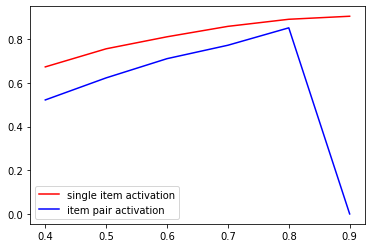

In [34]:
plot_activation_index(minsup_values, activation_index_single_items_list, activation_index_pairs_list)

In [35]:
# Evaluating how the activation index with different minconfs

minconf_values = []
activation_index_single_items_list = []
activation_index_pairs_list = []

for minconf in range(4,10):
    
    frequent_sets, activation_index_single_items, activation_index_pairs = evaluate_apriori_sets(amenities, item_set, 0.5, minconf/10)
    
    activation_index_single_items_list.append(activation_index_single_items)
    
    activation_index_pairs_list.append(activation_index_pairs)
    
    minconf_values.append(minconf/10)

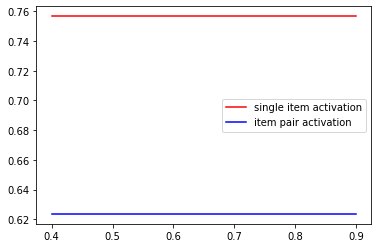

In [36]:
plot_activation_index(minsup_values, activation_index_single_items_list, activation_index_pairs_list)

As seen in the analysis above, the minimum support is the most important parameter for the apriori algorithm as it's directly correlated with the created "activation_index" metric. Which is not interesting for explaining a model.

In [37]:
# Checking the most common item pairs with the minimum of 75% confidence and then for 40%
frequent_items_40, rules_40 = apriori(item_set, 0.40, 0.5)
frequent_pair_40 = list_relevant_pairs(frequent_items_40)

frequent_items_75, rules_75 = apriori(item_set, 0.75, 0.5)
frequent_pair_75 = list_relevant_pairs(frequent_items_75)

frequent_items_85, rules_85 = apriori(item_set, 0.85, 0.5)
frequent_pair_85 = list_relevant_pairs(frequent_items_75)

In [38]:
frequent_pair_40

[['amn_hot', 'amn_water'],
 ['amn_elevator', 'amn_iron'],
 ['amn_hanger', 'amn_dedicated'],
 ['amn_term', 'amn_hot'],
 ['amn_wifi', 'amn_dish'],
 ['amn_kitchen', 'amn_washer'],
 ['amn_refrigerator', 'amn_wifi'],
 ['amn_stove', 'amn_silverware'],
 ['amn_long', 'amn_conditioning'],
 ['amn_conditioning', 'amn_water'],
 ['amn_kitchen', 'amn_elevator'],
 ['amn_term', 'amn_tv'],
 ['amn_stay', 'amn_basic'],
 ['amn_dish', 'amn_air'],
 ['amn_allowed', 'amn_elevator'],
 ['amn_hanger', 'amn_dish'],
 ['amn_hanger', 'amn_water'],
 ['amn_wifi', 'amn_dedicated'],
 ['amn_stay', 'amn_hot'],
 ['amn_wifi', 'amn_workspace'],
 ['amn_wifi', 'amn_tv'],
 ['amn_washer', 'amn_elevator'],
 ['amn_kitchen', 'amn_parking'],
 ['amn_allowed', 'amn_hanger'],
 ['amn_wifi', 'amn_essential'],
 ['amn_air', 'amn_iron'],
 ['amn_dish', 'amn_stove'],
 ['amn_hanger', 'amn_hot'],
 ['amn_dish', 'amn_water'],
 ['amn_kitchen', 'amn_hanger'],
 ['amn_stay', 'amn_silverware'],
 ['amn_premise', 'amn_conditioning'],
 ['amn_term', 'amn_

In [39]:
frequent_pair_75

[['amn_wifi', 'amn_stay'],
 ['amn_term', 'amn_stay'],
 ['amn_kitchen', 'amn_stay'],
 ['amn_wifi', 'amn_term'],
 ['amn_air', 'amn_conditioning'],
 ['amn_kitchen', 'amn_wifi'],
 ['amn_kitchen', 'amn_term'],
 ['amn_long', 'amn_term'],
 ['amn_wifi', 'amn_long'],
 ['amn_kitchen', 'amn_long'],
 ['amn_long', 'amn_stay']]

In [40]:
frequent_pair_85

[['amn_wifi', 'amn_stay'],
 ['amn_term', 'amn_stay'],
 ['amn_kitchen', 'amn_stay'],
 ['amn_wifi', 'amn_term'],
 ['amn_air', 'amn_conditioning'],
 ['amn_kitchen', 'amn_wifi'],
 ['amn_kitchen', 'amn_term'],
 ['amn_long', 'amn_term'],
 ['amn_wifi', 'amn_long'],
 ['amn_kitchen', 'amn_long'],
 ['amn_long', 'amn_stay']]

The words pairs don't necessarily make sense in literal terms, therefore, single items could also be viable, as long as a feature selection stage is applied.

In [41]:
item_counting = (((amenities > 0).sum(axis = 0)/amenities.shape[0]).sort_values(ascending = False))
limited_item_counting = item_counting[0: 20]

In [42]:
px.bar(x = limited_item_counting.index, y = limited_item_counting.values)

## Amenities: Correlation analysis

In [43]:
# Retrieving the complete listings to join on index with amenities
complete_listings = pd.read_csv(data_filepath + 'listings_post_etl.csv', index_col = 0)

# Checking if the indices match
complete_listings.shape[0] == amenities.shape[0]

True

In [44]:
# Applying the above_median_metric
complete_listings = above_median_metric(complete_listings)

# Limiting to the top 40 most common items in amenities for this analysis
limited_item_counting = item_counting[0:40]
column_focus = list(limited_item_counting.index)
limited_amenities = amenities[column_focus]

# Joining the datasets
joined_amenities = limited_amenities.join(complete_listings.above_median)

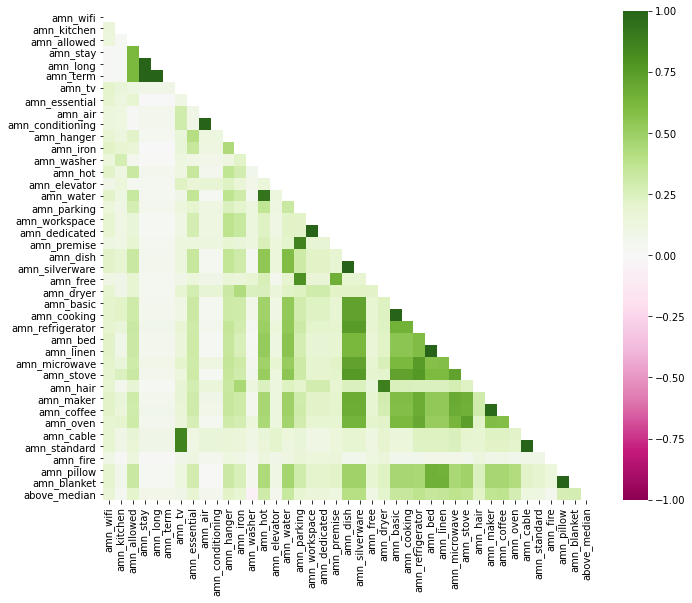

In [45]:
correlation_test = correlation_analysis(joined_amenities, 'spearman')

In [46]:
# As seen in the correlation matrix above, it seems that assessing strings with high correlations with other strings
# is an efficient way of removing redundant columns

redundant_columns = []

# Looping rows from the dataset
for row, series in enumerate(correlation_test[0:len(correlation_test) - 1]):
    # Looping the columns in the current Series of the current row
    for column in range(0, row):

        if correlation_test.iloc[row, column] > 0.8 and row != column:
            print(correlation_test.index[row][4:] + '_' + correlation_test.columns[column][4:])
            redundant_columns.append(correlation_test.columns[column])

redundant_columns = list(set(redundant_columns))

joined_amenities.drop(redundant_columns, axis = 1, inplace = True)

long_stay
term_stay
term_long
conditioning_air
water_hot
dedicated_workspace
premise_parking
silverware_dish
free_parking
cooking_basic
linen_bed
hair_dryer
coffee_maker
cable_tv
standard_tv
standard_cable
blanket_pillow


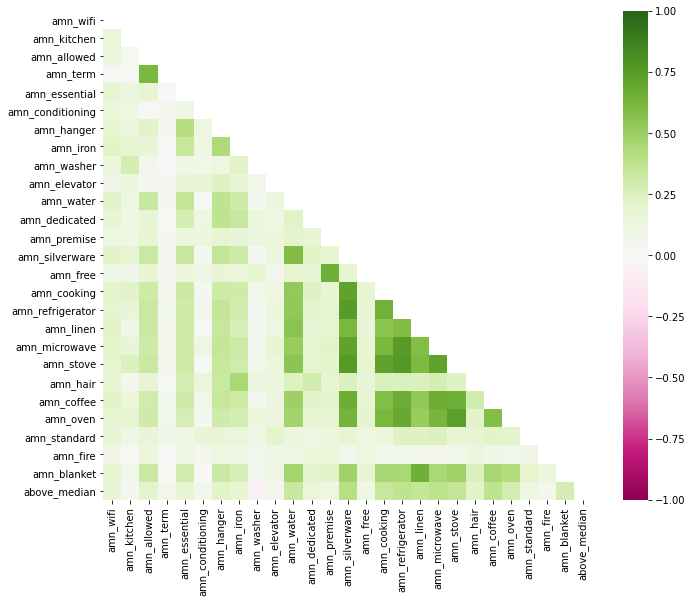

In [47]:
correlation_test = correlation_analysis(joined_amenities, 'spearman')

**Chosen NLP approach:** dropping redundant columns based on highly correlated strings

## Complete dataset characterization

In [48]:
# Loading libraries for EDA
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Loading the modules created based on the previous EDA steps
from modelling_support import prioritize_and_drop_redundant_columns
from modelling_support import above_median_metric

In [49]:
# Reading data and joining a dataset with the assayed parameters
amenities = pd.read_csv(data_filepath + 'amenities_post_etl.csv', index_col = 0)
listings = pd.read_csv(data_filepath + 'listings_post_etl.csv', index_col = 0)

filtered_amenities = prioritize_and_drop_redundant_columns(amenities, 0.8, 40)

df = listings.join(filtered_amenities)
df = above_median_metric(df)
df.dropna(inplace = True)

df.head()

id  host_id  host_response_time  host_response_rate  host_is_superhost  \
0  17878    68997                 1.0                 1.0                  0   
1  24480    99249                 4.0                 1.0                  0   
2  25026   102840                 3.0                 0.8                  0   
3  35636   153232                 1.0                 1.0                  1   
4  35764   153691                 1.0                 1.0                  1   

   host_has_profile_pic  host_identity_verified  accommodates  bedrooms  beds  \
0                     1                       1             5       2.0   2.0   
1                     1                       1             2       1.0   1.0   
2                     1                       1             3       1.0   1.0   
3                     1                       1             2       1.0   1.0   
4                     1                       1             2       1.0   1.0   

   ...  amn_linen  amn_microwave  amn_stove  amn_hair  amn_coffee  amn_oven  \
0  ...          1              1          1         1           1         1   
1  ...          1              1          0         1           1         0   
2  ...          1              1          1         1           1         1   
3  ...          1              1          1         1           1         1   
4  ...          1              1          1         1           1         0   

   amn_standard  amn_fire  amn_blanket  above_median  
0             1         0            0             1  
1             1         0            1             1  
2             1         0            0             1  
3             1         0            0             1  
4             1         1            1             1  

[5 rows x 62 columns]

In [50]:
def two_dimensional_scatter_plot(X_reduced, y):
    '''
    INPUTS:
    X_reduced - (np.array) with two columns and n rows
    y - (array) with one column and n rows
    
    OUTPUTS:
    none
    
    DESCRIPTION:
    Plots a 2D scatter plot using the data created with a dimensionality reduction algorithm
    '''
    # Re-joining the dataset
    df_reduced = pd.DataFrame(X_reduced, columns = ['component_1', 'component_2'])
    df_reduced['y'] = y

    # Plotting the data to search for possible clusters
    sns.scatterplot(data = df_reduced, x = 'component_1', y = 'component_2', hue = 'y')

In [51]:
# Listing the input columns to filter the DataFrame
input_columns = []

for column in df.columns:
    if column != 'above_median':
        input_columns.append(column)
        
# Retrieving the dataset values to process the data on sklearn
X = df[input_columns].values
y = df['above_median'].values

<AxesSubplot:>

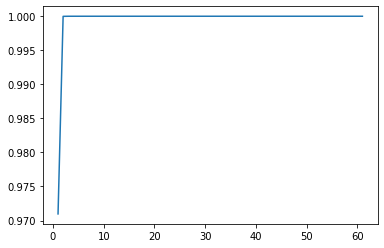

In [52]:
# Pricipal Component Analysis

# Normalizing the values for PCA
X_normalized = Normalizer().fit_transform(X)

explained_variance = []
tested_n_components = []

for n_components in range(1, len(df.columns)):
    pca = PCA(n_components = n_components).fit(X_normalized, y)
    tested_n_components.append(n_components)
    explained_variance.append(pca.explained_variance_ratio_.sum())

sns.lineplot(x = tested_n_components, y = explained_variance)

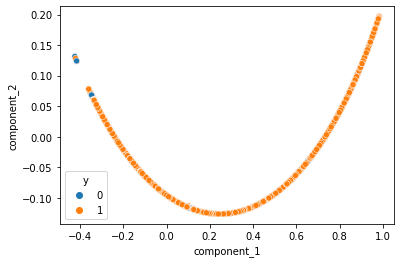

In [53]:
# Reducing the dataset to its first two principal components
pca_two_components = PCA(n_components = 2).fit(X_normalized)
X_reduced_pca = pca_two_components.transform(X_normalized)

two_dimensional_scatter_plot(X_reduced_pca, y)

In [54]:
pca_weights = np.transpose(pca_two_components.components_[0: len(input_columns)])

pca_component_weight = pd.DataFrame(pca_weights, index = input_columns, columns = ['component_1', 'component_2'])
pca_component_weight.sort_values(['component_1', 'component_2'], ascending = False)

pca_component_weight[0:20]

component_1   component_2
id                           7.363928e-01 -6.765538e-01
host_id                     -6.765543e-01 -7.363924e-01
host_response_time           1.275891e-08 -4.483895e-07
host_response_rate           1.420559e-08 -2.430083e-07
host_is_superhost            9.615599e-09 -1.019380e-07
host_has_profile_pic         1.403121e-08 -2.625942e-07
host_identity_verified       1.577842e-08 -2.398400e-07
accommodates                 8.178127e-08 -1.376596e-06
bedrooms                     3.019911e-08 -5.488023e-07
beds                         4.537410e-08 -8.458474e-07
price                        2.741338e-05 -3.455368e-04
minimum_nights_avg_ntm       8.397224e-08 -1.220048e-06
maximum_nights_avg_ntm       9.969428e-06 -1.405150e-04
review_scores_rating         6.292709e-08 -1.234549e-06
review_scores_accuracy       6.509409e-08 -1.237757e-06
review_scores_cleanliness    6.350876e-08 -1.219526e-06
review_scores_checkin        6.653524e-08 -1.274844e-06
review_scores_communication  6.628445e-08 -1.270724e-06
review_scores_location       6.867337e-08 -1.271280e-06
review_scores_value          6.302556e-08 -1.200006e-06

In [55]:
pca_component_weight[40:61]

component_1   component_2
amn_conditioning  1.224967e-08 -2.115584e-07
amn_hanger        1.147592e-08 -2.039031e-07
amn_iron          1.115982e-08 -2.183197e-07
amn_washer        1.450616e-08 -2.178436e-07
amn_elevator      8.035284e-09 -1.218113e-07
amn_water         1.068706e-08 -2.273128e-07
amn_dedicated     8.919448e-09 -1.631424e-07
amn_premise       1.136964e-08 -1.760444e-07
amn_silverware    7.666698e-09 -1.973979e-07
amn_free          1.024539e-08 -1.428410e-07
amn_cooking       1.003020e-08 -1.863953e-07
amn_refrigerator  7.220694e-09 -1.944032e-07
amn_linen         7.398611e-09 -1.786176e-07
amn_microwave     6.393320e-09 -1.837745e-07
amn_stove         7.553251e-09 -1.857138e-07
amn_hair          7.330070e-09 -1.804282e-07
amn_coffee        1.106386e-08 -2.298509e-07
amn_oven          6.977872e-09 -1.535478e-07
amn_standard      1.774208e-09 -1.508920e-07
amn_fire          5.203748e-09 -1.029111e-07
amn_blanket       7.636402e-09 -1.590285e-07

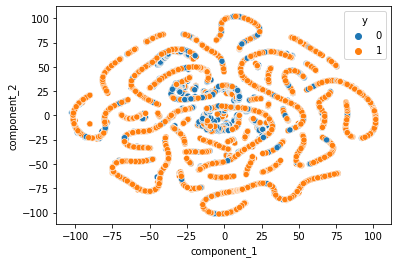

In [56]:
# Attempt to visualize possible clusters using the t-SNE approach
X_reduced_tsne = TSNE(n_components = 2).fit_transform(X_normalized)

two_dimensional_scatter_plot(X_reduced_tsne, y)

## EDA key observations:
The dataset presents skewed distributions and low correlated data using the Spearman method, which indicates that classification models based on linear regressions may not be efficient for the given problem. <br/><br/>
Regarding the NLP approach, the main difficulties are the fact that the list of strings for amenities doesn't have standardized strings, having different variations of the same item, such as different sized TVs. In this case, the Apriori approach resulted in item pairs that didn't necessarily had a grammatical meaning, which would result in a model with low interpretability. As a result of that, the chosen approach was to minimize the complexity of the dataset by discarding highly correlated (Spearman method) string pairs. <br/><br/>
Finally, dimensionality reduction approaches such as PCA and t-SNE didn't result in visual clusters separating the output. <br/><br/>
In the case of PCA, the explained variance showed an abrupt increase with a low amuont of variables, indicating that most of the inputs aren't linearly correlated to their respective outputs. <br/><br/>
In the case of t-SNE, 2D clusters couldn't be efficiently visualized with the proposed dimensionality reduction approach based on the sample probability distribution.